In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import gurobipy as gp
from gurobipy import GRB
import json

In [2]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [3]:
rng = np.random.default_rng(43)

# Scaling bounds & Capture efficiency

# Code

### Bootstrap

In [4]:
def bootstrap(sample, beta, N, tau, drop=False):
    """
    Bootstrap estimate of probabilities of all states in the sample
    Set bounds outside tau threshold truncation to [0, 1]

    sample: integer sample
    N: number of bootstrap resamples
    tau: truncation threshold
    drop: if true, values outside truncation are removed from the sample before bootstrap
    """

    # OB truncation bounds
    xmin, xmax = int(sample.min()), int(sample.max())
    sample_counts = np.bincount(sample, minlength=(xmax + 1))
    t_indices = np.where(sample_counts > tau)[0]
    tmin, tmax = int(t_indices.min()), int(t_indices.max())

    # if drop: remove values outside the truncation before bootstrapping
    if drop:
        # indices below
        Itmin = (sample >= tmin)
        # drop
        sample = sample[Itmin]
        beta = beta[Itmin]

        # indices above
        Itmax = (sample <= tmax)
        # drop
        sample = sample[Itmax]
        beta = beta[Itmax]

    # bootstrap
    prob_intervals = np.empty((2, xmax + 1))
    prob_intervals[0, :] = 0
    prob_intervals[1, :] = 1
    fm_intervals = np.empty((2, xmax + 1))
    fm_intervals[0, :] = 0
    fm_intervals[1, :] = 1

    # resample
    prob_resamples = rng.choice(sample, size=(N, len(sample)))

    # estimate over truncation
    for x in range(tmin, tmax + 1):

        '''probs'''
        # proportion of x per resample
        prob_estimates = (prob_resamples == x).mean(axis=1)
        # interval
        prob_intervals[:, x] = np.quantile(prob_estimates, [0.025, 0.975])

        '''fms'''
        # capture for cells with x observed counts
        beta_x = beta[sample == x]
        # resample
        beta_resamples = rng.choice(beta_x, size=(N, len(beta_x)))
        # estimate E[beta|m]
        fm_estimate = beta_resamples.mean(axis=1)
        # quantile for confidence intervals
        fm_intervals[:, x] = np.quantile(fm_estimate, [0.025, 0.975], axis=0)

    return tmin, tmax, prob_intervals, fm_intervals

### Standard Optimization (Downsampled)

Treat bootstrap intervals as bounds on (downsampled) probabilities

\begin{align*}
    & \hat{p_{L}} \le p(x) \le \hat{p_{U}} \quad , \quad \forall x \in \{0, \ldots m\} \\
    & \sum \limits_{x=0}^{m} p(x) \le 1 \\
    & Q(f)p = 0
\end{align*}

In [5]:
def optimize_downsampled_standard(xmax, tmin, tmax, prob_intervals, fm_intervals, CME=True, silent=True, printing=True, time_limit=300, dist_opt=True):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            f = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="f", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() <= 1, name="Distribution")

            # probability bounds
            model.addConstr(p[:(tmax+1)] <= prob_intervals[1, :(tmax+1)], name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= prob_intervals[0, :(tmax+1)], name="prob_LB")

            # f rate bounds
            model.addConstr(f[:(tmax+1)] <= fm_intervals[1, :(tmax+1)], name="f_UB")
            model.addConstr(f[:(tmax+1)] >= fm_intervals[0, :(tmax+1)], name="f_LB")

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            if CME:
                model.addConstr(
                    z == p[1] - k_tx * f[0] * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        z == k_tx * f[x - 1] * p[x - 1] + (x + 1) * p[x + 1] - (k_tx * f[x] + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x"
                )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((xmax + 1, 2))
                for x in range(xmax + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

### Scaling Optimization (Downsampled)

Treat bootstrap intervals as bounds on (downsampled) probabilities **relative** to the observed mass of the sample, bounding the unobserved mass from above (assume relatively small):

\begin{align*}
    & \hat{p_{L}} \le \frac{p(x)}{p(obs)} \le \hat{p_{U}} \quad , \quad \forall x \in \{0, \ldots m\} \\
    & p(obs) = \sum \limits_{x=0}^{m} p(x) \quad , \quad p(unobs) = \sum \limits_{x=m+1}^{M} p(x) \\
    & p(obs) + p(unobs) = 1 \\
    & p(unobs) \le UB \\
    & Q(f)p = 0
\end{align*}

In [6]:
def optimize_downsampled_scaling(xmax, tmin, tmax, prob_intervals, fm_intervals, silent=True, printing=True, time_limit=300,
                  CME=True, dist_opt=True, UB=1):
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            f = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="f", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() == 1, name="Distribution")

            # bounds on the unobserved mass
            model.addConstr(p[(tmax+1):] <= UB, name="Unobserved_ub")

            # probability bounds
            p_obs = p[:(tmax+1)].sum()
            model.addConstr(p[:(tmax+1)] <= prob_intervals[1, :(tmax+1)] * p_obs, name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= prob_intervals[0, :(tmax+1)] * p_obs, name="prob_LB")

            # f rate bounds
            model.addConstr(f[:(tmax+1)] <= fm_intervals[1, :(tmax+1)], name="f_UB")
            model.addConstr(f[:(tmax+1)] >= fm_intervals[0, :(tmax+1)], name="f_LB")

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            if CME:
                model.addConstr(
                    z == p[1] - k_tx * f[0] * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        z == k_tx * f[x - 1] * p[x - 1] + (x + 1) * p[x + 1] - (k_tx * f[x] + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((xmax + 1, 2))
                for x in range(xmax + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

# Running

## No capture efficiency

Assume there is no capture efficiency ($\beta = 1$) and compare the results produced by:

(1) downsampled standard optimization \
(2) downsampled scaling optimization \
(3) scaling optimization

The difference between downsampled vs not is the use of state dependent rates $f_{x}$ in the CME equations $Q(f)p = 0$:

$$ f_{x} = \mathbb{E}[\beta \vert x] $$

Interval estimates on these are produced by bootstrapping the mean $\beta$ for cells where $x$ counts were observed. Inevitably, adding a variable (which is bounded) weakens the CME constraints and so will produce wider output bounds.

But for $\beta = 1$ we might expect that if $f_{x}$'s are bounded in intervals of $[1, 1]$ then the downsampled scaling (2) and scaling (3) will produce the same results. **However**, we can only bootstrap $f_{x}$ for **observed** $x$ i.e. $x \in \{0, \ldots, m\}$; for unobserved states $x$ i.e. $x \in \{m + 1, \ldots, M\}$ we can only bound by the interval $[0, 1]$, and so downsampled scaling (2) produces weaker output bounds than (3).

If when $\beta = 1$ we set all $f_{x} = 1$ in downsampled scaling (2) then results will be the same as (3), as shown below:

In [7]:
# (3) Scaling optimization (without any capture efficiency consideration)
def optimize_scaling(xmax, tmin, tmax, prob_intervals, silent=True, printing=True, time_limit=300,
                  CME=True, dist_opt=True, UB=1):
    '''
    (3) Scaling optimization without any capture efficiency consideration
    '''
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() == 1, name="Distribution")

            # bounds on the unobserved mass
            model.addConstr(p[(tmax+1):] <= UB, name="Unobserved_ub")

            # probability bounds
            p_obs = p[:(tmax+1)].sum()
            model.addConstr(p[:(tmax+1)] <= prob_intervals[1, :(tmax+1)] * p_obs, name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= prob_intervals[0, :(tmax+1)] * p_obs, name="prob_LB")

            # CME
            if CME:
                model.addConstr(
                    0 == p[1] - k_tx * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        0 == k_tx * p[x - 1] + (x + 1) * p[x + 1] - (k_tx + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((xmax + 1, 2))
                for x in range(xmax + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

In [8]:
# (2) Downsampled scaling optimization (BUT with all f = 1)
def optimize_downsampled_scaling_perfect(xmax, tmin, tmax, prob_intervals, silent=True, printing=True, time_limit=300,
                  CME=True, dist_opt=True, UB=1):
    '''
    (2) Downsampled scaling optimization BUT with all f = 1
    '''
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            f = model.addMVar(shape=(xmax + 1), vtype=GRB.CONTINUOUS, name="f", lb=1, ub=1) # set f = 1 (assume perfect capture)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() == 1, name="Distribution")

            # bounds on the unobserved mass
            model.addConstr(p[(tmax+1):] <= UB, name="Unobserved_ub")

            # probability bounds
            p_obs = p[:(tmax+1)].sum()
            model.addConstr(p[:(tmax+1)] <= prob_intervals[1, :(tmax+1)] * p_obs, name="prob_UB")
            model.addConstr(p[:(tmax+1)] >= prob_intervals[0, :(tmax+1)] * p_obs, name="prob_LB")

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            if CME:
                model.addConstr(
                    z == p[1] - k_tx * f[0] * p[0],
                    name="CME_0"
                )

                model.addConstrs(
                    (
                        z == k_tx * f[x - 1] * p[x - 1] + (x + 1) * p[x + 1] - (k_tx * f[x] + x) * p[x] for x in range(1, xmax)
                    ),
                    name="CME_x"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            if solution['min_status'] == "INFEASIBLE":
                model.computeIIS()
                model.write('iis-mmt.ilp')

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((xmax + 1, 2))
                for x in range(xmax + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

In [188]:
# settings
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30

# simulate & bootstrap (no capture: beta = 1)
sample = rng.poisson(k, size=n)
beta = np.ones(n)
sample_downsampled = rng.binomial(sample, beta)
tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

In [195]:
# (1) Downsampled standard optimization
solution_1 = optimize_downsampled_standard(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False)

k_tx in (1.8566376760653363, 2.0015727931296063), status OPTIMAL, OPTIMAL


In [196]:
# (2) Downsampled scaling optimization
solution_2 = optimize_downsampled_scaling(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=0.1)

k_tx in (1.85460790709107, 99.9999856973594), status OPTIMAL, OPTIMAL


In [197]:
# (2) Downsampled scaling optimization (BUT with all f = 1)
solution_2f = optimize_downsampled_scaling_perfect(xmax, tmin, tmax, prob_intervals, dist_opt=False, UB=0.1)

k_tx in (1.854610478688959, 1.9614028040002545), status OPTIMAL, OPTIMAL


In [198]:
# (3) Scaling optimization (no capture efficiency considered)
solution_3 = optimize_scaling(xmax, tmin, tmax, prob_intervals, dist_opt=False, UB=0.1)

k_tx in (1.8546104551272058, 1.9614814962393172), status OPTIMAL, OPTIMAL


For $\beta = 1$ downsampled scaling (2) gives a very weak upper bound because $f_{x}$'s for tail states $x$ are only bounded by $[0, 1]$ (despite $f_{x}$'s for observed states bounded by $[1, 1]$). As disussed, if we fix all $f_{x} = 1$ then the bounds produced are equal to those from (no capture) scaling optimiation (3).

Note that the scaling optimizations produce roughly the same bounds as downsampled standard optimization (1) (with the exception of (2)'s poor upper bound).

### Distribution bounds

In [14]:
def plot_distribution_results(bootstrap_intervals, solution_intervals, beta, title):

    # truncate bootstrap bounds
    bootstrap_intervals[:, :tmin] = None
    bootstrap_intervals[:, (tmax+1):] = None

    # compute true distribution
    p = np.zeros(xmax + 1)
    for b in beta:
        p += scipy.stats.poisson.pmf([m for m in range(xmax + 1)], b * k) / len(beta)
    p_obs = p[:(tmax + 1)]
    p_unobs = p[(tmax + 1):]

    # plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    plt.suptitle(f"Bounds on distribution: {title}")

    # bounds on observed mass
    axs[0].set_title("Observed states")
    axs[0].plot(bootstrap_intervals[0, :], color="green", label="Bootstrap intervals")
    axs[0].plot(bootstrap_intervals[1, :], color="green")
    axs[0].plot(solution_intervals['p'][:(tmax + 1), 0], color="blue", label="Optimization bounds")
    axs[0].plot(solution_intervals['p'][:(tmax + 1), 1], color="blue")
    axs[0].plot(p_obs, color="red", label="True distribution")
    axs[0].legend()
    axs[0].set_xlabel("x")
    axs[0].set_ylabel("p(x)")

    # bounds on unobserved mass
    axs[1].set_title("Unobserved states")
    axs[1].plot(solution_intervals['p'][(tmax+1):, 0], color="blue", label="Optimization bounds")
    axs[1].plot(solution_intervals['p'][(tmax+1):, 1], color="blue")
    axs[1].plot(p_unobs, color="red", label="True distribution")
    axs[1].legend()
    axs[1].set_xticks(range(0, xmax - tmax, 2))
    axs[1].set_xticklabels(range(tmax + 1, xmax + 1, 2))
    axs[1].set_xlabel("x")
    axs[1].set_ylabel("p(x)")

In [10]:
# settings
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30 # reduce to speedup optim

# simulate & bootstrap (no capture: beta = 1)
sample = rng.poisson(k, size=n)
beta = np.ones(n)
sample_downsampled = rng.binomial(sample, beta)
tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

In [ ]:
# (1) Downsampled standard optimization
solution_1 = optimize_downsampled_standard(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=True)

In [ ]:
plot_distribution_results(prob_intervals, solution_1, beta, "(1) Downsampled standard optimization")

In [12]:
# (3) Scaling optimization (no capture efficiency considered)
solution_3 = optimize_scaling(xmax, tmin, tmax, prob_intervals, dist_opt=True, UB=0.1)

k_tx in (1.8426052585369601, 2.0412796072272914), status OPTIMAL, OPTIMAL


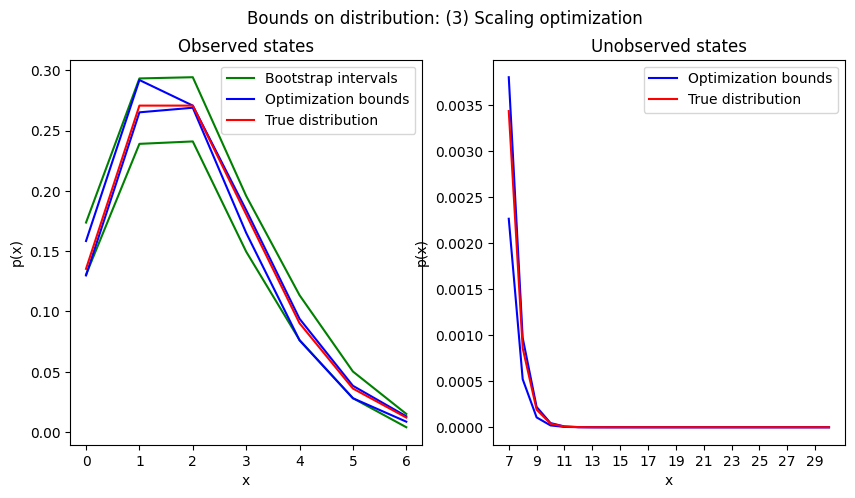

In [15]:
plot_distribution_results(prob_intervals, solution_3, beta, "(3) Scaling optimization")

## Capture efficiency

While the lack of $f_{x}$ bounds for unobserved $x$ is an unfortunate drawback, we can still investigate the performance of downsampled scaling optimization across a range of capture efficiencies.

For a given capture efficiency:

- optimize downsampled standard (1)
- for a range of mass bounds optimize downsampled scaling (2)
- plot the change in bounds of (2) against (1)

In [44]:
# settings
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30 # reduce to speedup optim

# simulate
sample = rng.poisson(k, size=n)

# downsample
mean_capture = 0.1
beta = rng.beta(1, (1 / mean_capture) - 1, size=n)
sample_downsampled = rng.binomial(sample, beta)

# bootstrap
tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

# Downsampled standard optimization
solution_standard = optimize_downsampled_standard(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False)

# compute true unobserved mass
p_obs = np.zeros(tmax + 1)
for b in beta:
    p_obs += scipy.stats.poisson.pmf([m for m in range(tmax + 1)], b * k) / len(beta)
m_obs = sum(p_obs)
m_unobs = 1 - sum(p_obs)
print(f"p(obs) = {m_obs}")
print(f"p(unobs) = {m_unobs}")

# un-observed mass range
umubs = np.linspace(0.2, m_unobs, 10)

# store results
bounds = np.empty((2, len(umubs)))

# optimize
for i, umub in enumerate(umubs):
    solution_bound = optimize_downsampled_scaling(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=umub, printing=False)
    bounds[0, i] = solution_bound['min']
    bounds[1, i] = solution_bound['max']

k_tx in (1.5638895070794696, 2.4610278018188416), status OPTIMAL, OPTIMAL
p(obs) = 0.995729841267858
p(unobs) = 0.004270158732141982


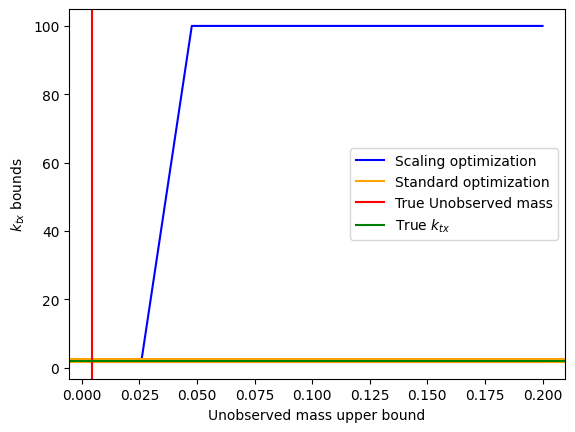

In [45]:
plt.plot(umubs, bounds[0, :], color="blue", label="Scaling optimization")
plt.plot(umubs, bounds[1, :], color="blue")
plt.axhline(solution_standard['min'], color="orange", label="Standard optimization")
plt.axhline(solution_standard['max'], color="orange")
plt.axvline(m_unobs, color="red", label="True Unobserved mass")
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Unobserved mass upper bound")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("")
plt.legend()

In [54]:
# settings
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30 # reduce to speedup optim

# simulate
sample = rng.poisson(k, size=n)

# mean capture efficiencies
mean_capture_range = [i / 10 for i in range(1, 11)]

colours = ["blue", "orange", "green", "red", "purple", "pink", "yellow", "black"]

# store results
bounds = np.empty((len(mean_capture_range), 2, 10))

for i, mean_capture in enumerate(mean_capture_range):

    # downsample
    b = (1 / mean_capture) - 1
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=n)
    sample_downsampled = rng.binomial(sample, beta)

    # bootstrap
    tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

    # compute true unobserved mass
    p_obs = np.zeros(tmax + 1)
    for b in beta:
        p_obs += scipy.stats.poisson.pmf([m for m in range(tmax + 1)], b * k) / len(beta)
    m_obs = sum(p_obs)
    m_unobs = 1 - sum(p_obs)

    # un-observed mass range
    umubs = np.linspace(1, m_unobs, 10)

    # optimize
    for j, umub in enumerate(umubs):
        solution_bound = optimize_downsampled_scaling(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=umub, printing=False)
        bounds[i, 0, j] = solution_bound['min']
        bounds[i, 1, j] = solution_bound['max']

21 min

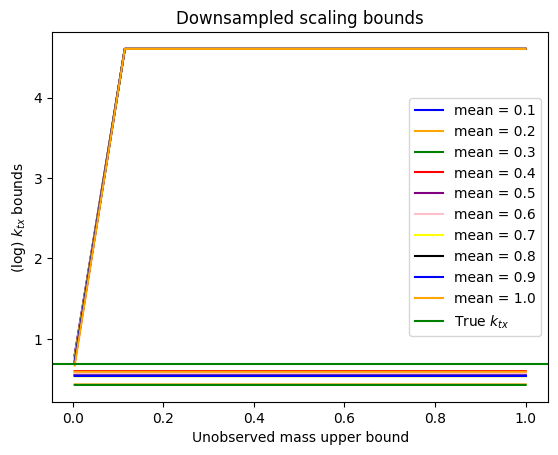

In [ ]:
m = 10
for i, mean_capture in enumerate(mean_capture_range):
    plt.plot(umubs[:m], np.log(bounds[i, 0, :m]), color=colours[i % 8], label=f"mean = {mean_capture}")
    plt.plot(umubs[:m], np.log(bounds[i, 1, :m]), color=colours[i % 8])

plt.axhline(np.log(k), color="green", label=r"True $k_{tx}$")
plt.xlabel("Unobserved mass upper bound")
plt.ylabel(r"(log) $k_{tx}$ bounds")
plt.title("Downsampled scaling bounds")
plt.legend()

In [73]:
mean_capture

1.0

#### Tightest scaling bounds

Bounds when UB = p(unobs) true value

NOTE: ignore upper bounds as all = K (100)

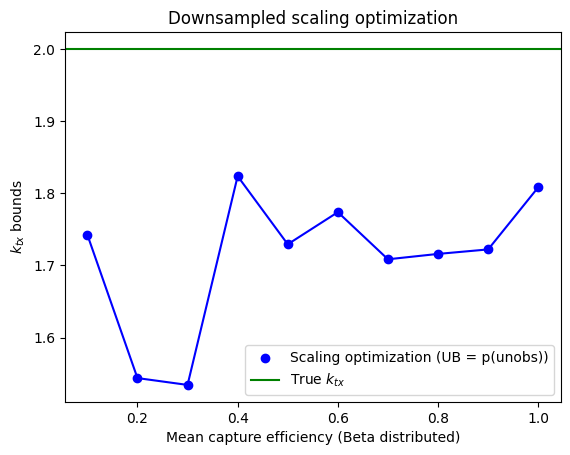

In [75]:

# scaling bounds when UB = p(unobs) true value (tightest bounds produced)
min_bounds = bounds[:, :, 0]

# plot
plt.scatter(mean_capture_range, min_bounds[:, 0], color="blue", label="Scaling optimization (UB = p(unobs))")
#plt.scatter(mean_capture_range, min_bounds[:, 1], color="blue")
plt.plot(mean_capture_range, min_bounds[:, 0], color="blue")
#plt.plot(mean_capture_range, min_bounds[:, 1], color="blue")
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Mean capture efficiency (Beta distributed)")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Downsampled scaling optimization")
plt.legend()

### Standard optimization

For comparison show the parameter bounds produced by standard optimization across a range of capture efficiencies

In [ ]:
# settings
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30 # reduce to speedup optim

# simulate
sample = rng.poisson(k, size=n)

# mean capture range
mean_capture_range = [i / 10 for i in range(1, 11)]

# b range
b_range = [(1 / mean) - 1 for mean in mean_capture_range]

# store bounds
standard_bounds = np.empty((2, len(b_range)))

for i, b in enumerate(b_range):

    # sample capture
    if b == 0:
        beta = np.ones(n)
    else:
        beta = rng.beta(1, b, size=n)
    
    # downsample
    sample_downsampled = rng.binomial(sample, beta)

    # bootstrap
    tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

    # Downsampled standard optimization
    solution_standard = optimize_downsampled_standard(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, printing=False)

    # store
    standard_bounds[0, i] = solution_standard['min']
    standard_bounds[1, i] = solution_standard['max']

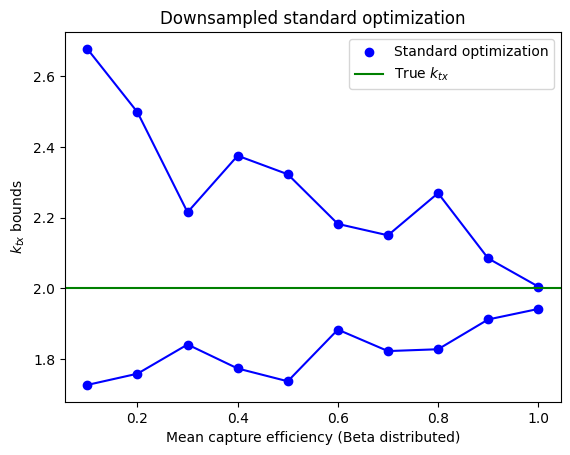

In [ ]:
plt.scatter(mean_capture_range, standard_bounds[0, :], color="blue", label="Standard optimization")
plt.scatter(mean_capture_range, standard_bounds[1, :], color="blue")
plt.plot(mean_capture_range, standard_bounds[0, :], color="blue")
plt.plot(mean_capture_range, standard_bounds[1, :], color="blue")
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Mean capture efficiency (Beta distributed)")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Downsampled standard optimization")
plt.legend()

### Comparison

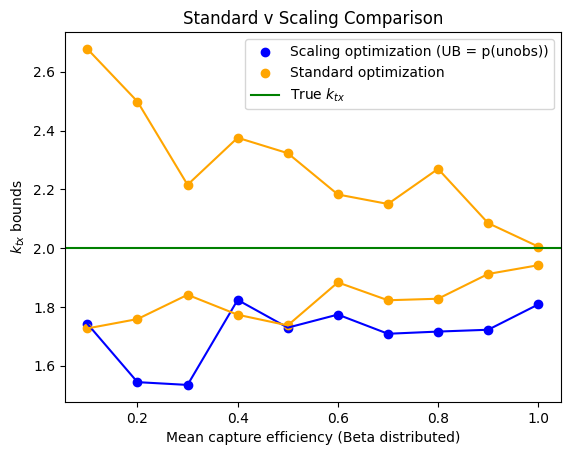

In [76]:
# scaling bounds when UB = p(unobs) true value (tightest bounds produced)
min_bounds = bounds[:, :, 0]

# scaling
plt.scatter(mean_capture_range, min_bounds[:, 0], color="blue", label="Scaling optimization (UB = p(unobs))")
#plt.scatter(mean_capture_range, min_bounds[:, 1], color="blue")
plt.plot(mean_capture_range, min_bounds[:, 0], color="blue")
#plt.plot(mean_capture_range, min_bounds[:, 1], color="blue")

# standard
plt.scatter(mean_capture_range, standard_bounds[0, :], color="orange", label="Standard optimization")
plt.scatter(mean_capture_range, standard_bounds[1, :], color="orange")
plt.plot(mean_capture_range, standard_bounds[0, :], color="orange")
plt.plot(mean_capture_range, standard_bounds[1, :], color="orange")

# plot
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Mean capture efficiency (Beta distributed)")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Standard v Scaling Comparison")
plt.legend()

## Notes

- plot standard bounds against capture range (% not b so realistic)
- plot scaling bounds against UB for range of capture (on same graph?)

- too slow to optimize p for downsampled methods??

### Poisson data

In [147]:
k = 2
tau = 5
N = 1000
n = 1000
xmax = 30

sample = rng.poisson(k, size=n)
beta = rng.beta(1, 2, size=n)
sample_downsampled = rng.binomial(sample, beta)
tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

In [148]:
p_obs = np.zeros(tmax + 1)
for b in beta:
    p_obs += scipy.stats.poisson.pmf([m for m in range(tmax + 1)], b * k) / len(beta)
print(f"p(obs) = {sum(p_obs)}")
print(f"p(unobs) = {1 - sum(p_obs)}")

p(obs) = 0.9958436842776812
p(unobs) = 0.004156315722318782


In [ ]:
# true (un)observed mass
p_obs = np.zeros(tmax + 1)
for b in beta:
    p_obs += scipy.stats.poisson.pmf([m for m in range(tmax + 1)], b * k) / len(beta)
print(f"p(obs) = {sum(p_obs)}")
print(f"p(unobs) = {1 - sum(p_obs)}")

In [149]:
# Standard
solution = optimize_standard(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False)

k_tx in (1.8650383568872853, 2.6168230228644407), status OPTIMAL, OPTIMAL


In [153]:
# Scaling
solution = optimize_scaling(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=0.1)
solution = optimize_scaling(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=0.01)

k_tx in (1.94422956842235, 99.99661759929762), status OPTIMAL, OPTIMAL
k_tx in (1.9442160665525228, 2.635128425969253), status OPTIMAL, OPTIMAL


### Non-poisson data

In [117]:
from interaction_inference import simulation

In [132]:
params = {
    'k_on_1': 1,
    'k_on_2': 1,
    'k_off_1': 1,
    'k_off_2': 1,
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 2
}

sample = simulation.gillespie_telegraph(params, 1000)
x1_sample = np.array([x[0] for x in sample])

In [133]:
beta = rng.beta(1, 2, size=n)
sample_downsampled = rng.binomial(x1_sample, beta)
tmin, tmax, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

In [134]:
# Standard
solution = optimize_standard(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False)

k_tx in (0.3297851812244912, 0.4605224023490482), status OPTIMAL, OPTIMAL


In [135]:
# Scaling
solution = optimize_scaling(xmax, tmin, tmax, prob_intervals, fm_intervals, dist_opt=False, UB=0.1)

k_tx in (0.32972013160906655, 99.99999999930894), status OPTIMAL, OPTIMAL
